In [1]:
%load_ext autoreload
%autoreload 2

In [504]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import apogee_analysis as aah
import sys
sys.path.append("../")
from plotting import fig_saver
from scipy.integrate import quad
import yields
import vice
import carbon_yield_plots as cat

In [3]:
sf = fig_saver("figures")

Below, we investigate the equilibrium trends using a simple formalism. To begin, recall that the equilibrium abundance for carbon is 

$$
\dot{M}_c = y_c^{cc} \dot{M}_\star + y_c^{agb} \langle \dot{M}_\star \rangle_{agb} - (1 + \eta - r) Z_c \dot{M}_\star
$$

Where
$$
\langle \dot{M}_\star \rangle_{agb}(T) = \int_0^T \dot{M}_\star(t) f_{agb}(T - t)\ dt
$$
where $f_{agb}$ is the fraction of AGB stars with a lifetime $t$. If we make the approximation that all AGB stars have the same lifetime, $\tau_{agb} \approx 3$, we can write:
$$
\langle \dot{M}_\star \rangle_{agb}(T) =\dot{M}_\star(T - \tau_{agb}) 
$$

We can solve the first equation for the equilibrium abundace under an exponentially declining SFH: $\dot{M_g}/M_g = -1/\tau_{sfh}$, as
$$
Z_c^{eq} = \frac{y_c^{cc} + y_c^{agb} \frac{\langle \dot{M}_\star \rangle_{agb}}{\dot{M}_\star} }{1 + \eta - r - \tau_\star/\tau_{sfh}}
$$

Also, make the approximation that $y_c^{agb} = \alpha + Z \beta$ where $\alpha$ and $\beta$ are arbitrary coefficients representing the limiting low metallicity carbon AGB yield and the AGB yield dependence on metalicity. To further simplify, assume an exponentially declining SFH: $\dot{M}_\star \propto e^{-t/\tau_{sfh}}$, we can write 
$$
\frac{\langle \dot{M}_\star \rangle_{agb}}{\dot{M}_\star} = e^{\tau_{agb}/\tau_{sfh}}
$$
Using these substitutions, we can write:
$$
Z_c^{eq}(R) = \frac{y_c^{cc} + (\alpha + \beta Z(R))  e^{\frac{\tau_{agb}}{\tau_{sfh}(R)}} }{1 + \eta(R) - r - \tau_\star / \tau_{sfh}}
$$

Since we also know the equilibrium abundance of oxygen:
$$
Z_o^{eq}(R) = \frac{y_o^{cc}}{1 + \eta(R) - r - \tau_\star / \tau_{sfh}}
$$
we can make plots of \[C/O\]-\[O/H\] of the equilibrium abundance tracks, which should be an accurate approximation of the model results.

## Constraint of y_c_cc from least squares

We begin by assuming some parameters are fixed: $y_{O, 0}^{cc}$, $f_C^{agb}$, $y_C^{agb}$, and the SFH, $\dot{M}_\star(t)$. Let $\langle y_c^{agb} \rangle$ be the effective present day agb yield. In other words, the weigted average of $y_c^{agb}$ over the SFH and IMF:
$$
\langle y_c^{agb} \rangle = \diamond = \frac{\int_0^T y_c^{agb}(M, Z) \dot{M}_\star(T - t) \frac{dN}{dM} \frac{dM}{dt} dt  }{ \dot{M}_\star \int_0^T \frac{dN}{dM} \frac{dM}{dt} dt}
$$ 




We want to estimate two parameters: $y_C^{cc}$, and $\varpi$, the factor reducing both $y_Z^{cc}$ and $\eta$ similarly.

Starting with the definition of $f_C^{agb}$:

$$
f_C^{agb} = \frac{y_c^{agb}\diamond}{\varpi y_C^{cc} + y_C^{agb}\diamond}
$$

we can solve this for $\varpi$:

$$
\varpi = \frac{y_C^{agb}\diamond}{y_c^{cc}} \zeta 
$$
$\zeta = \left(\frac{1}{f_c^{agb}} - 1\right)$

With these definiions, 
$$
y_C^{cc} = \frac{\zeta \eta}{\frac{\zeta + 1}{Z_c} + \frac{r - 1}{ \langle y_c^{agb} \rangle} }
$$

In [7]:
out = vice.output("output/cristallo11")
def get_value(name, i=-1):
    return np.array([out.zones["zone%i" % (int(10*j))].history[name][i] for j in R])

In [271]:
Z = get_value("z")
eta = get_value("eta_0")
r = get_value("r_eff")
sfr = get_value("sfr")
Mg = get_value("mgas")
dt = 0.1
Mg_dot = (Mg - get_value("mgas", i=-11))/dt
Mstar = get_value("mstar")
tau_sfh = - Mg/Mg_dot
tau_star = Mg/(sfr * 10**9)
t = out.zones["zone0"].history["time"]
dt = 0.01

MoverH = np.log10(Z/0.014)

R = np.arange(3, 11, 0.1)

In [272]:
def m_star(R, t):
    T = int(100*t) - 1
    if type(R) in (list, np.array, tuple, np.ndarray):
        return [out.zones["zone%i" % int(i)].history["sfr"][T] for i in 10*R]
    else:
        i = int(10*R)
        return out.zones["zone%i" % int(i)].history["sfr"][T]

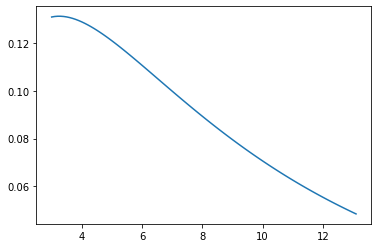

In [11]:
t = np.arange(3, 13.2, 0.1)
plt.plot(t, [m_star(R, T)[6] for T in t])

In [12]:
y_agb = vice.yields.agb.interpolator("c", study="cristallo11")

In [312]:
def imf(m):
    return m**-2.3

def dn_dt(t):
    return imf(m_to(t)) * (-1/35) * (t/10)**(-4.5/3.5)
    
def m_to(t):
    return (t/10)**(-1/3.5)

def t_to(m):
    return 10*m**-3.5

def t_int(f, t_f=13.2):
    return quad(f, t_to(8), t_f)[0]

def y_agb_ave(i):
    """returns the time-averaged agb yield at present day, so effective y_c^{agb}"""   

    z = Z[i]
    r = R[i]
    mdot_star = sfr[i]
    t_max = 13.2
    return t_int(lambda t: m_star(r, t_max - t) * y_agb(m_to(t), z) * dn_dt(t), t_max) /t_int(dn_dt) / mdot_star

In [313]:
y_agb_a = np.array([y_agb_ave(i) for i in range(len(Z))])

<ipython-input-312-64531d61c0da>:14: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(f, t_to(8), t_f)[0]
<ipython-input-312-64531d61c0da>:14: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(f, t_to(8), t_f)[0]


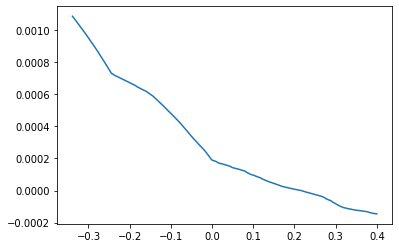

In [314]:
plt.plot(MoverH, y_agb_a)

# set f_agb

In [435]:
fe_h = MoverH
fe_h = np.append(fe_h, 2 * fe_h[-1] - fe_h[-2])[::-1]
bins, means, sds, counts = aah.calc_mean_v21("[fe/h]", "[c/h]", bins = fe_h)
err_means = sds/np.sqrt(counts)
Z_1 = (0.014*10**((bins[1:] + bins[:-1])/2))[::-1]
Z_c = vice.solar_z("c") * 10**means[::-1]
Z_c_err = np.abs(np.log(10) * Z_c) * err_means[::-1]

/home/daniel/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [437]:
f_agb = 0.2
zeta = (1/f_agb - 1)

y_c_cc = zeta *eta/( (zeta + 1)/Z_c + (r - 1)/y_agb_a )
y_c_cc_err = zeta * eta * (zeta + 1)/Z_c**2 / ((zeta + 1)/Z_c + (r - 1)/y_agb_a)**2 * Z_c_err

In [438]:
pii = zeta * y_agb_a / y_c_cc
eta_adj = pii*eta
eta_adj_err = eta_adj/y_c_cc * y_c_cc_err

In [505]:
# if Z_c > Z_c_crit, then no amount of reducing outflows can
# accieve the required f_agb while producing the correct amount of 
# carbon since the minimum outflow is 0 in this model, so there is 
# a minimum value of the agb contribution

Z_c_crit = y_agb_a * (zeta + 1) / (1 - r)
R_filt = Z_c_crit > Z_c

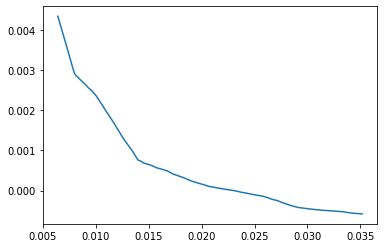

In [518]:
plt.plot(Z, y_c_cc*pii)

Text(0, 0.5, 'f_agb_max')

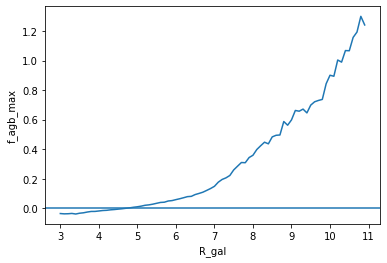

In [509]:
plt.plot(R, y_agb_a/Z_c/(1-r))
plt.axhline(0)
plt.xlabel("R_gal")
plt.ylabel("f_agb_max")

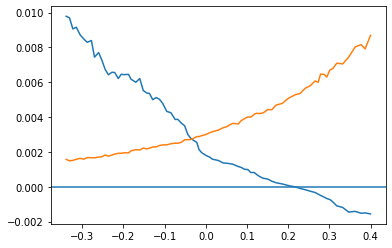

In [440]:
plt.plot(MoverH, Z_c_crit)
plt.plot(MoverH, Z_c)
plt.axhline(0)

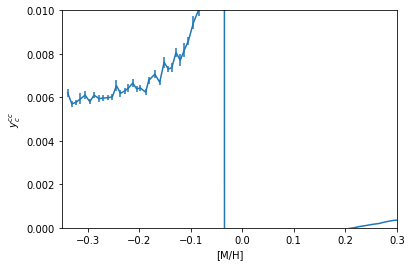

In [441]:
plt.errorbar(MoverH, y_c_cc, yerr = y_c_cc_err)
plt.xlabel("[M/H]")
plt.ylabel("$y_c^{cc}$")
plt.xlim(-0.35,0.3)
plt.ylim(0, 0.01)
sf("y_c_cc_calc")

(0.0, 1.1048838097400018)

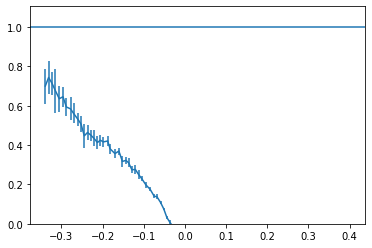

In [442]:
plt.errorbar(MoverH, pii, yerr=eta_adj_err)
plt.axhline(1)
plt.ylim(0)

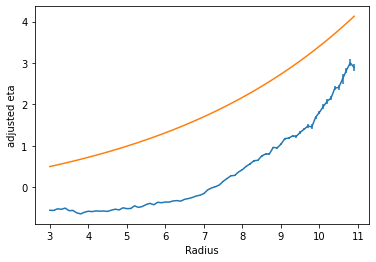

In [443]:
plt.errorbar(R, eta_adj, yerr=eta_adj_err)
plt.ylabel("adjusted eta")
plt.xlabel("Radius")
plt.plot(R, eta)

In [444]:
def calc_equlibrium(y_o_cc = 0.015):
    denom = 1 + eta_adj - r - tau_star/tau_sfh

    o_eq = y_o_cc/denom

    c_eq = (y_c_cc + y_agb_a)/denom

    o_h = aah.abundance_to_bracket(o_eq, "O")
    c_h = aah.abundance_to_bracket(c_eq, "C")
    c_o = c_h - o_h
    return o_h, c_o

In [445]:
d = 1 + eta_adj - r - tau_star/tau_sfh

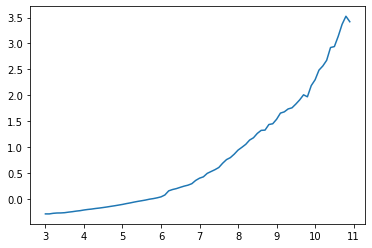

In [446]:
plt.plot(R, d)

In [447]:
vice.solar_z("c")

0.00236

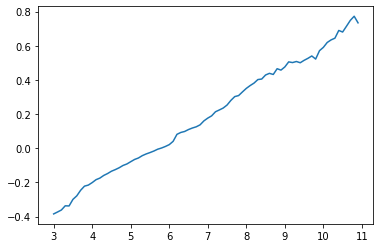

In [448]:
plt.plot(R, d/(1+eta - r - tau_star/tau_sfh))

In [500]:
def compare_track(label=""):
    fig, axs = plt.subplots(1, 3, figsize=(20,5))
        
    # equilibrium track
    ax = axs[0]
    ax.plot(*calc_equlibrium(), label=label)
    aah.plot_mean_v21("[o/h]", "[c/o]", xlim=(-0.5, 0.5), ax=ax)
    
    ax.set(xlim=(-0.6, 0.4), xlabel="[o/h]", ylabel="[c/o]")
    ax.legend()

    
    # CC yield
    ax = axs[1]
    cat.plot_ycyo(ax=ax)
    y_o = 0.015
    ycyo = np.log10(y_c_cc / y_o) - np.log10(vice.solar_z("c")/vice.solar_z("o"))
    ax.errorbar(MoverH[R_filt], ycyo[R_filt], label="calculated")

    
    # percentage
    ax = axs[2]
    
    ax.errorbar(R, eta_adj, yerr = eta_adj_err, label="adj eta")
    ax.plot(R, eta, label="eta_0")
    ax.set(xlabel="R", ylabel="eta")
    


In [501]:
def compare_track2(label=""):
    R_filt = Z_c_crit > Z_c
    o_h, c_o = calc_equlibrium()
    
    plt.plot(o_h[R_filt], c_o[R_filt], label=label)
    
    aah.plot_mean_v21("[o/h]", "[c/o]", xlim=(-0.5, 0.5))
    

    plt.xlim(-0.6, 0.4)
    plt.xlabel("[o/h]")
    plt.ylabel("[c/o]")


/home/daniel/surp/apogee_analysis.py:167: RuntimeWarning: invalid value encountered in log10
  return np.log10(data/vice.solar_z(ele))
/home/daniel/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


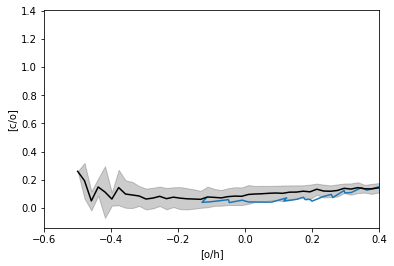

In [502]:
compare_track2()

/home/daniel/surp/apogee_analysis.py:167: RuntimeWarning: invalid value encountered in log10
  return np.log10(data/vice.solar_z(ele))
/home/daniel/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/daniel/surp/carbon_yield_plots.py:129: ScienceWarning: Supernovae yields from the Woosley & Weaver (1995) ApJ, 101, 181 study are sampled on a grid of stellar masses up to 40 Msun at this metallicity. Employing an upper mass limit larger than this may introduce numerical artifacts. Got: 100 Msun
  yo = [vice.yields.ccsne.fractional('o', study=study, MoverH=metalicity, rotation=rotation)[0]
/home/daniel/surp/carbon_yield_plots.py:129: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  yo = [vice.yields.ccsne.fractional('o', study=study, MoverH=metalicity, rotation=

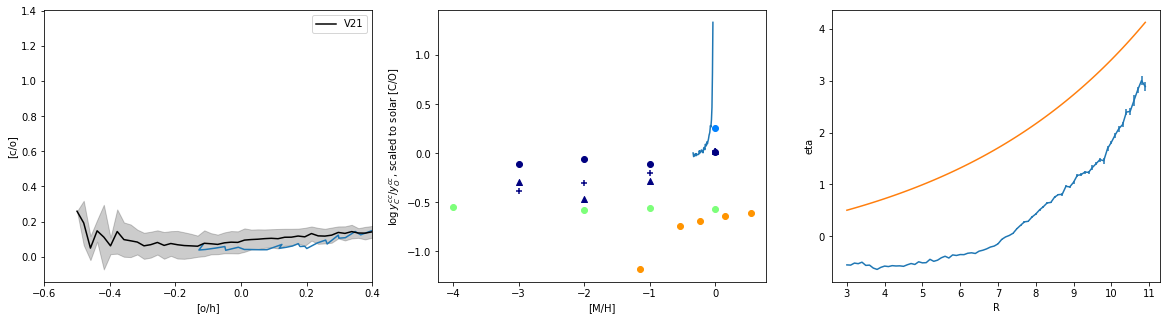

In [503]:
compare_track()

In [525]:
def calc_equlibrium(y_o_cc = 0.015):
    denom = 1 + eta - r# - tau_star/tau_sfh

    o_eq = y_o_cc/denom

    c_eq = (y_c_cc*pii + y_agb_a)/denom

    o_h = aah.abundance_to_bracket(o_eq, "O")
    c_h = aah.abundance_to_bracket(c_eq, "C")
    c_o = c_h - o_h
    return o_h, c_o

/home/daniel/surp/apogee_analysis.py:167: RuntimeWarning: invalid value encountered in log10
  return np.log10(data/vice.solar_z(ele))
/home/daniel/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


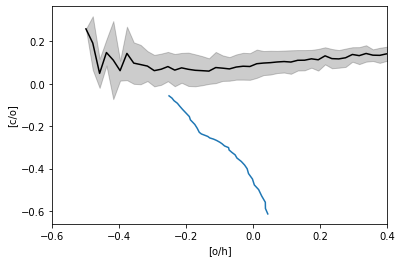

In [526]:
compare_track2()